In [1]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_name = "DIC-C2DH-HeLa"
dataset_path = os.path.join(".", "cell_detection_dataset")
if not os.path.exists(dataset_path):
    url = ("http://data.celltrackingchallenge.net/training-datasets/"
           + f"{dataset_name}.zip")
    download_url(url, ".") # (1)
    _extract_zip(f"{dataset_name}.zip", dataset_path, None) # (2)
    os.remove(f"{dataset_name}.zip") # (3)

This script downloads the dataset \wingding{1}, unzips it into the \lstinline{dataset_path} directory \wingding{2}, and removes the downloaded zip file \wingding{3}.

In [2]:
train_image_path = os.path.join(dataset_path, "DIC-C2DH-HeLa", "02")
train_seg_path = os.path.join(dataset_path, "DIC-C2DH-HeLa", "02_ST", "SEG")

In [3]:
import cv2, glob

def load_images(path):
    """Load images."""
    images = []
    for file in glob.glob(path + "/*.tif"): # (1)
        image = cv2.imread(file, cv2.IMREAD_UNCHANGED) # (2)
        images.append(image) # (3)
    return images

train_images = load_images(train_image_path)
train_segs = load_images(train_seg_path)

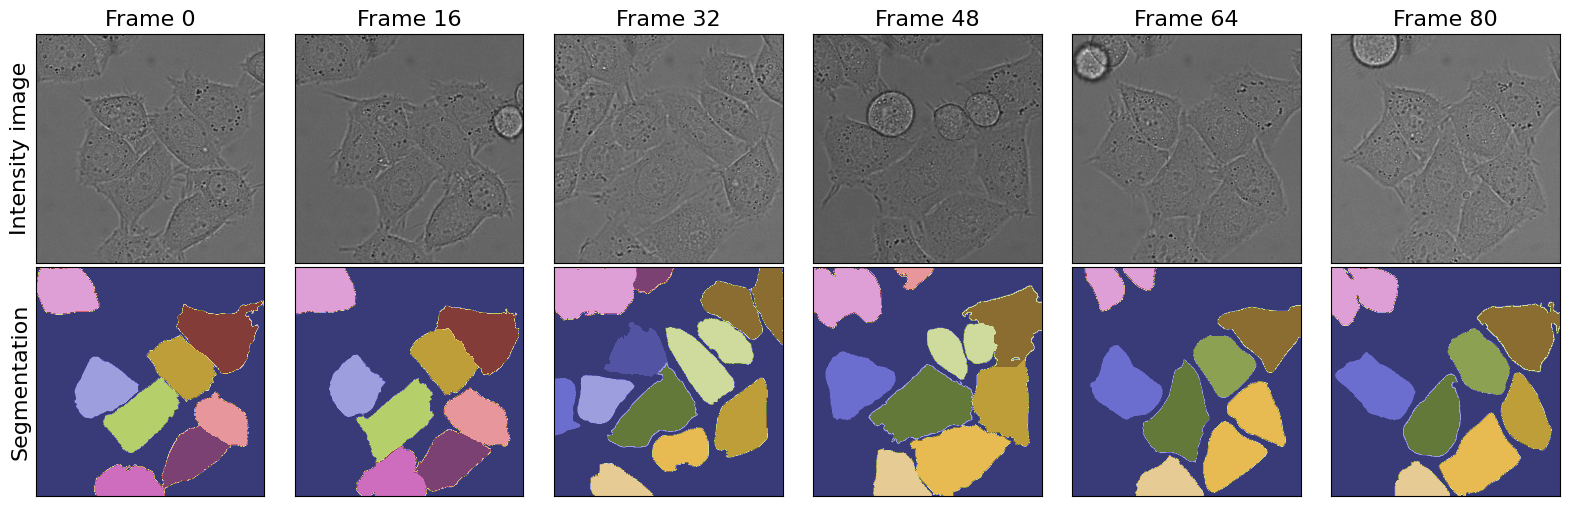

In [4]:
import matplotlib.pyplot as plt

frames_to_plot = [i for i in range(0, len(train_segs), len(train_segs) // 5)]

fig, axs = plt.subplots(2, len(frames_to_plot), figsize=(20, 6))
fig.patch.set_facecolor("white")
for i, frame in enumerate(frames_to_plot):
    axs[0, i].imshow(train_images[frame], cmap="gray")
    axs[0, i].set_title(f"Frame {frame}", fontsize=16)
    axs[0, i].tick_params(axis="both", which="both", bottom=False, top=False, 
                          left=False, right=False, labelleft=False, 
                          labelbottom=False)

    axs[1, i].imshow(train_segs[frame], cmap="tab20b")
    axs[1, i].tick_params(axis="both", which="both", bottom=False, top=False, 
                          left=False, right=False, labelleft=False, 
                          labelbottom=False)
    
    if i == 0:
        axs[0, i].set_ylabel("Intensity image", fontsize=16)
        axs[1, i].set_ylabel("Segmentation", fontsize=16)    

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

In [5]:
import numpy as np
import torch
from skimage import measure
from torch_geometric.data import Data

class GraphFromSegmentations:
    """Graph representation of the motion of cells."""
    
    def __init__(self, connectivity_radius, max_frame_distance):
        """Initialize graph."""
        self.connectivity_radius = connectivity_radius # (1)
        self.max_frame_distance = max_frame_distance # (2)

    def __call__(self, segmentations, relation):
        """"""
        x, node_index_labels, frames = [], [], []
        for frame, segmentation in enumerate(segmentations): # (3)
            features, index_labels = self.compute_node_features(segmentation) # (4)
            x.append(features) # (5)
            node_index_labels.append(index_labels) # (6)
            frames.append([frame] * len(features)) # (7)
        x = np.concatenate(x)
        node_index_labels = np.concatenate(node_index_labels)
        frames = np.concatenate(frames)

        edge_index, edge_attr = self.compute_connectivity(x, frames) # (8)
        edge_ground_truth = self.compute_ground_truth( # (9)
            node_index_labels, edge_index, relation
        )

        edge_index = edge_index.T
        edge_attr = edge_attr[:, None]
        edge_ground_truth = edge_ground_truth[:, None]

        graph = Data( # (10)
            x=torch.tensor(x, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float),
            distance=torch.tensor(edge_attr, dtype=torch.float),
            frames=torch.tensor(frames, dtype=torch.float),
            y=torch.tensor(edge_ground_truth, dtype=torch.float),
        )

        return graph

    def compute_node_features(self, segmentation):
        """Compute node features."""
        labels = np.unique(segmentation)
        
        x, indices = [], []
        for label in labels[1:]:
            mask = segmentation == label
            props = measure.regionprops(mask.astype(np.int32))[0]

            centroids = props.centroid / np.array(segmentation.shape)
            eccentricity = props.eccentricity

            x.append([*centroids, eccentricity])
            indices.append(label)
            
        return x, indices

    def compute_connectivity(self, x, frames):
        """Compute connectivity."""
        positions = x[:, :2]
        distances = np.linalg.norm(positions[:, None] - positions, axis=-1)

        frame_diff = (frames[:, None] - frames) * -1

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr

    def compute_ground_truth(self, indices, edge_index, relation):
        """Compute ground truth."""
        sender = indices[edge_index[:, 0]] 
        receiver = indices[edge_index[:, 1]]
        self_connections_mask = sender == receiver

        relation_indices = relation[:, [-1, 0]] 
        relation_indices = relation_indices[relation_indices[:, 0] != 0]

        relation_mask = np.zeros(len(edge_index), dtype=bool)
        for i, (s, r) in enumerate(zip(sender, receiver)):
            if np.any((relation_indices == [s, r]).all(1)): 
                relation_mask[i] = True

        ground_truth = self_connections_mask | relation_mask

        return ground_truth

In [6]:
graph_constructor = GraphFromSegmentations(connectivity_radius=0.2, 
                                           max_frame_distance=2)

In [7]:
train_graph = graph_constructor(
    segmentations=train_segs, 
    relation=np.loadtxt(os.path.join(dataset_path, "DIC-C2DH-HeLa", "02_GT", \
        "TRA", "man_track.txt"), dtype=int)
    )

In [8]:
print("Number of nodes:", len(train_graph.x))
print("Number of edges:", len(train_graph.edge_index[0]))

Number of nodes: 988
Number of edges: 2997


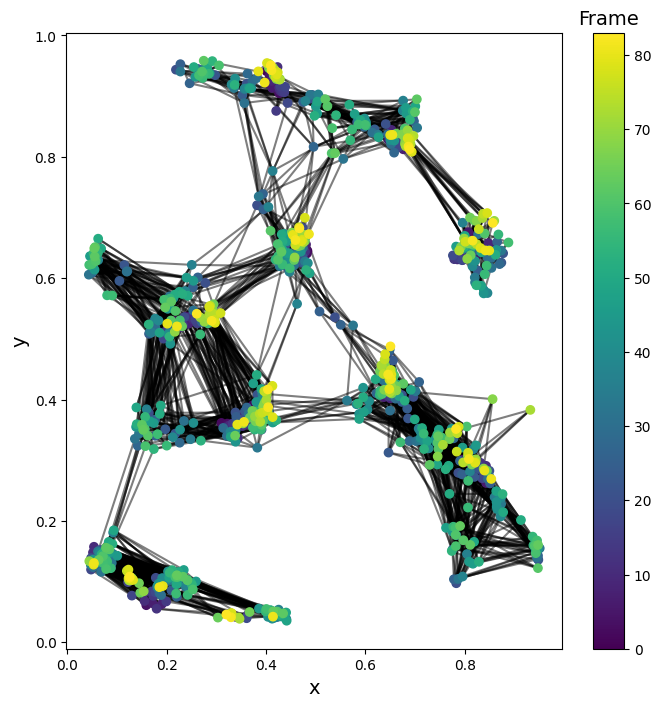

In [9]:
plt.figure(figsize=(8, 8))
for i, j in train_graph.edge_index.T:
    plt.plot([train_graph.x[i, 1], train_graph.x[j, 1]],
             [train_graph.x[i, 0], train_graph.x[j, 0]],
             c="black", alpha=0.5)
plt.scatter(train_graph.x[:, 1], train_graph.x[:, 0], 
            c=train_graph.frames, cmap="viridis", zorder=10)
cb = plt.colorbar()
cb.ax.set_title('Frame', fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

In [10]:
from torch.utils.data import Dataset

class CellTracingDataset(Dataset):
    """Class to prepare the graph dataset."""
    
    def __init__(self, graph, window_size, dataset_size, transform=None):
        """Initialize the graph dataset."""
        self.graph = graph

        self.window_size = window_size # (1)
        self.dataset_size = dataset_size

        frames, edge_index = graph.frames, graph.edge_index
        self.pair_frames = torch.stack(
            [frames[edge_index[0, :]], frames[edge_index[1, :]]], axis=1
        )
        self.frames = frames
        self.max_frame = frames.max()

        self.transform = transform 

    def __len__(self):
        """Obtain length of dataset."""
        return self.dataset_size

    def __getitem__(self, idx):
        frame_idx = np.random.randint(self.window_size, self.max_frame + 1) # (2)

        start_frame = frame_idx - self.window_size
        node_mask = (self.frames >= start_frame) & (self.frames < frame_idx) # (3)
        x = self.graph.x[node_mask] # (4)

        edge_mask = ((self.pair_frames >= start_frame) 
                     & (self.pair_frames < frame_idx)) # (5)
        edge_mask = edge_mask.all(axis=1) 

        edge_index = self.graph.edge_index[:, edge_mask] # (6)
        edge_index -= edge_index.min() 

        edge_attr = self.graph.edge_attr[edge_mask] # (7)

        # sample ground truth edges
        ground_truth_edges = self.graph.y[edge_mask] # (8)

        graph = Data( # (9)
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            distance=edge_attr,
            y=ground_truth_edges,
        )

        if self.transform: # (10)
            graph = self.transform(graph)

        return graph

This class divides the training graph into smaller subgraphs.
The \lstinline{window_size} parameter determines the number of frames in each subgraph \wingding{1}. 
The dataset generates subgraphs by randomly sliding a window across the training graph \wingding{2}. 
The subgraph is constructed by extracting nodes \wingding{3}\wingding{4} 
and edges \wingding{5}\wingding{6}\wingding{7}\wingding{8} within the window. 
The dataset returns the subgraph as a PyTorch data object \wingding{9}. 

To further enhance the training dataset, additional augmentations can be applied to the subgraphs. 
This class provides the flexibility to include custom augmentations by specifying the \lstinline{transform} parameter \wingding{10}. 
For examples, Listing~\ref{cd:11:B:aug} defines two augmentations.

In [11]:
import math, torch

class RandomRotation: # (1)
    """Random rotation."""
    
    def __call__(self, graph):
        """Call the random rotation."""
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        angle = np.random.rand() * 2 * np.math.pi
        rotation_matrix = torch.tensor(
            [
                [math.cos(angle), -math.sin(angle)],
                [math.sin(angle), math.cos(angle)],
            ]
        )
        rotated_features = torch.matmul(centered_features, rotation_matrix)

        graph.x[:, :2] = rotated_features + 0.5
        return graph
    
class RandomFlip: # (2)
    """Random flip."""
    
    def __call__(self, graph):
        """Call the random flip."""
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        if np.random.randint(2):
            centered_features[:, 0] *= -1
        
        if np.random.randint(2):
            centered_features[:, 1] *= -1
        
        graph.x[:, :2] = centered_features + 0.5
        return graph

In [12]:
from torchvision import transforms

train_dataset = CellTracingDataset(
    train_graph,
    window_size=5,
    dataset_size=512, # (1)
    transform=transforms.Compose([RandomRotation(), RandomFlip()]),
)

In [13]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


\subsection{Training MAGIK}

MAGIK is similar to message-passing neural networks that we have seen in previous examples. However, the main difference is that MAGIK implements a local attention mechanism that allows the model to concentrate on specific nodes and edges during message passing. This mechanism comes into play when aggregating messages to a node. Each message's contribution has a weight that depends on the distance between the connected nodes through a function with learnable parameters defining a learnable local receptive field. With this mechanism, MAGIK can focus on relevant distance-based features during message passing, which is crucial for cell tracking tasks.

\subsubsection{Instantiating MAGIK}

You can instantiate the MAGIK model using Listing~\ref{cd:11:B:MAGIK}.

In [14]:
import deeplay as dl
import torch.nn as nn

model = dl.GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)
model.encoder[0].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (2)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96, out_activation=nn.ReLU) # (3)
model.head.configure(hidden_features=[64, 32])

print(model) # (4)

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=32, bias=True)
          (activation): Layer[ReLU]()
        )
        (1): LinearBlock(
          (layer): Layer[Linear](in_features=32, out_features=64, bias=True)
          (activation): Layer[ReLU]()
        )
        (2): LinearBlock(
          (layer): Layer[Linear](in_features=64, out_features=96, bias=True)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
     

This code instantiates a simplified version of MAGIK, which is a message-passing neural network \wingding{1}. The model has four layers, and each layer contains 96 hidden features. Along with the message-passing layers, the model also includes a node encoder, an edge encoder, and a classification head. 

The node and edge encoder are configured with three hidden layers, each with 32, 64, and 96 hidden features. The classification head consists of two hidden layers with 64 and 32 hidden features and a final output layer with a single output and a sigmoid activation function \wingding{2}\wingding{3}. You can print a detailed model summary using \lstinline{print{model}}.

In [15]:
classifier = dl.BinaryClassifier(model=model, optimizer=dl.Adam(lr=1e-3))
classifier = classifier.create()

trainer = dl.Trainer(max_epochs=10)
trainer.fit(classifier, train_loader)

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/utilities/model_summary/model_summary.py:454: A lay

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ GraphToEdgeMAGIK │ 25.0 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 25.0 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 25.0 K                                                                                               
Total estimated model params size (MB): 0

Output()

/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_17439/259575854.py:11: DeprecationWarning: `np.math` is 
a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with
`math`
  angle = np.random.rand() * 2 * np.math.pi

/Users/giovannivolpe/Documents/GitHub/DeepLearningCrashCourse/py_env_dlcc/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


In [16]:
test_image_path = os.path.join(dataset_path, "DIC-C2DH-HeLa", "01")
test_seg_path = os.path.join(dataset_path, "DIC-C2DH-HeLa", "01_ST", "SEG")

test_images = load_images(test_image_path)
test_segs = load_images(test_seg_path)

In [17]:
test_graph = graph_constructor(
    segmentations=test_segs, 
    relation=np.loadtxt(os.path.join(dataset_path, "DIC-C2DH-HeLa", "01_GT", \
        "TRA", "man_track.txt"), dtype=int)
    )

In [18]:
from sklearn.metrics import f1_score

classifier.eval()
pred = classifier(test_graph)
predictions = pred.detach().numpy() > 0.5

ground_truth = test_graph.y

score = f1_score(ground_truth, predictions)

print(f"Test F1 score: {score}")

Test F1 score: 0.8522039757994814


In [19]:
import networkx as nx

class ComputeTrajectories:
    """Computation of trajectories."""

    def __call__(self, graph, predictions):
        """Compute trajectories."""
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        """Prune edges."""
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames[graph.edge_index[0]], graph.frames[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

In [20]:
compute_trajectories = ComputeTrajectories()
trajectories = compute_trajectories(test_graph, predictions.squeeze())

/var/folders/nk/vplzgbvj0w1gpgk5h_j226480000gp/T/ipykernel_17439/3364811550.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  list_of_colors = plt.cm.get_cmap("tab20b", len(trajectories))


RuntimeError: Requested MovieWriter (ffmpeg) not available

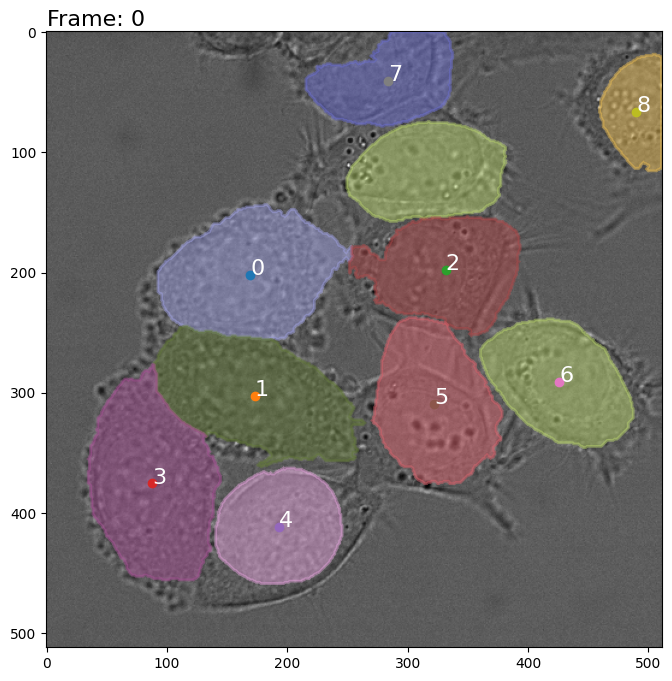

In [22]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from skimage import measure

fig, ax = plt.subplots(figsize=(8, 8))

list_of_colors = plt.cm.get_cmap("tab20b", len(trajectories))
np.random.shuffle(list_of_colors.colors)

def update(frame):
    """Update frame."""
    ax.clear()
    ax.imshow(test_images[frame], cmap="gray")

    segmentation = test_segs[frame]
    labels = np.unique(segmentation)

    for label in labels[1:]:
        contour = measure.find_contours(segmentation == label, 0.5)[0]
        ax.fill(
            contour[:, 1],
            contour[:, 0],
            color=list_of_colors(label),
            alpha=0.5,
            linewidth=2,
        )
    ax.text(0, -5, f"Frame: {frame}", fontsize=16, color="black")

    for idx, t in enumerate(trajectories):
        coordinates = test_graph.x[list(t)]
        frames = test_graph.frames[list(t)]

        coordinates_in_frame = coordinates[frames == frame]

        if len(coordinates_in_frame) == 0:
            continue

        ax.scatter(coordinates_in_frame[:, 1] * 512, coordinates_in_frame[:, 0] * 512)
        ax.text(
            coordinates_in_frame[0, 1] * 512,
            coordinates_in_frame[0, 0] * 512,
            str(idx),
            fontsize=16,
            color="white",
        )

        coordinates_previous_frames = coordinates[
            (frames <= frame) & (frames >= frame - 10)
        ]
        ax.plot(
            coordinates_previous_frames[:, 1] * 512,
            coordinates_previous_frames[:, 0] * 512,
            color="white",
        )

        ax.plot(
            coordinates_in_frame[max(0, frame - 10) : frame, 1] * 512,
            coordinates_in_frame[max(0, frame - 10) : frame, 0] * 512,
            color="red",
        )

    return ax

ani = FuncAnimation(fig, update, frames=len(test_segs))

html_video = HTML(ani.to_html5_video())
plt.close()
html_video